# 📥 Step 1: Load Libraries & Data


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#  Load Excel File
xls = pd.ExcelFile("Healthcare.xlsx")
df_appointments = pd.read_excel(xls, sheet_name="Appointments ")
df_doctors = pd.read_excel(xls, sheet_name=" Doctors")
df_patients = pd.read_excel(xls, sheet_name="Patients")
df_revenues = pd.read_excel(xls, sheet_name="Revenues")
df_expenses = pd.read_excel(xls, sheet_name="Expenses")


# 🧹 Step 2: Data Cleaning


In [6]:

# Convert Date columns to datetime
df_appointments['Date'] = pd.to_datetime(df_appointments['Date'])
df_revenues['Date'] = pd.to_datetime(df_revenues['Date'])

# Remove nulls and duplicates
for df in [df_appointments, df_doctors, df_patients, df_revenues, df_expenses]:
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)


# 🔗 Step 3: Merge Tables (Data Modeling)

In [8]:
# بنربط المواعيد مع المرضى والدكاترة عشان نشتغل على جدول شامل
df_merged = df_appointments.merge(df_patients, on="PatientID", how="left")
df_merged = df_merged.merge(df_doctors, on="DoctorID", how="left")


# 🔎 Step 4: Exploratory Data Analysis (Insights)


# ✅ No-show rate

In [11]:
# بنحسب نسبة المرضى اللي محضروش المواعيد
no_show_rate = (df_appointments['Status'].str.strip().str.lower() == 'no-show').mean() * 100
print(f"No-show Rate: {no_show_rate:.2f}%")


No-show Rate: 24.00%


# ✅ Returning patients


In [13]:
#بنحسب عدد المرضى اللي جم أكتر من مره
returning = df_appointments['PatientID'].value_counts()
returning = returning[returning > 1]
print(f"Returning patients: {len(returning)}")


Returning patients: 39


# ✅ Top busy doctors


In [15]:
#  بنشوف أكتر دكاتره عندهم مواعيد
top_doctors = df_appointments['DoctorID'].value_counts().head()
print(top_doctors)


DoctorID
6    20
1    18
7    18
3    17
9    14
Name: count, dtype: int64


# ✅ Specialty performance


In [17]:
# بنشوف أكتر تخصصات عليها ضغط (من جدول الدكاترة)
specialties = df_merged['Specialty_y'].value_counts()
print(specialties)


Specialty_y
Internal Medicine    69
Dentistry            32
Dermatology          26
Orthopedics          13
Pediatrics           10
Name: count, dtype: int64


# Most Busy Days of Week


In [19]:
df_appointments['DayOfWeek'] = df_appointments['Date'].dt.day_name()
busy_days = df_appointments['DayOfWeek'].value_counts()
print("Busy Days:\n", busy_days)

Busy Days:
 DayOfWeek
Monday       27
Friday       25
Thursday     24
Tuesday      23
Saturday     20
Sunday       16
Wednesday    15
Name: count, dtype: int64


#  Attendance Rate per Specialty

In [21]:
attendance_rate_specialty = df_merged.groupby('Specialty_y')['Status'].apply(lambda x: (x.str.strip().str.lower() != 'no-show').mean()*100)
print("Attendance Rate per Specialty:\n", attendance_rate_specialty)


Attendance Rate per Specialty:
 Specialty_y
Dentistry             71.875000
Dermatology           73.076923
Internal Medicine     76.811594
Orthopedics           69.230769
Pediatrics           100.000000
Name: Status, dtype: float64


# Avg Age per Specialty

In [23]:
avg_age_specialty = df_merged.groupby('Specialty_y')['Age'].mean()
print("Avg Age per Specialty:\n", avg_age_specialty)

Avg Age per Specialty:
 Specialty_y
Dentistry            45.500000
Dermatology          43.538462
Internal Medicine    47.000000
Orthopedics          50.076923
Pediatrics           43.300000
Name: Age, dtype: float64


# Revenue per Specialty

In [66]:
# تعديل اسم العمود في df_merged
df_merged = df_merged.rename(columns={'Specialty_y': 'Specialty'})

# دمج الإيرادات
df_merged_revenue = df_merged.merge(df_revenues, on=["Date", "Specialty"], how="left")

# حساب الإيرادات لكل تخصص
revenue_per_specialty = df_merged_revenue.groupby('Specialty')['Revenue'].sum().sort_values(ascending=False)
print("Revenue per Specialty:\n", revenue_per_specialty)


Revenue per Specialty:
 Specialty
Internal Medicine    123136.0
Dermatology           55603.0
Orthopedics           21109.0
Pediatrics            16127.0
Dentistry                 0.0
Name: Revenue, dtype: float64


# Monthly Net Profit

In [77]:
# تحويل تاريخ الإيرادات والمصروفات لشهور
df_revenues['Month'] = df_revenues['Date'].dt.to_period('M')
df_expenses['Month'] = df_expenses['Date'].dt.to_period('M')

# جمع الإيرادات والمصروفات شهريًا
monthly_rev = df_revenues.groupby('Month')['Revenue'].sum()
monthly_exp = df_expenses.groupby('Month')['Amount'].sum()

# دمج البيانات وحساب صافي الربح
monthly_profit = pd.DataFrame({
    'Revenue': monthly_rev,
    'Expenses': monthly_exp
})
monthly_profit['Net_Profit'] = monthly_profit['Revenue'] - monthly_profit['Expenses']

print("Monthly Net Profit:\n", monthly_profit)


Monthly Net Profit:
          Revenue  Expenses  Net_Profit
Month                                 
2025-05    79834     40374       39460
2025-06   181724     39085      142639
2025-07   121231     44074       77157


# Total Expenses per Type


In [81]:
expenses_per_type = df_expenses.groupby('Type')['Amount'].sum().sort_values(ascending=False)
print("Total Expenses per Type:\n", expenses_per_type)


Total Expenses per Type:
 Type
Medical Supplies    53856
Maintenance         22349
Rent                21707
Salaries            15991
Utilities            9630
Name: Amount, dtype: int64


# 📊 Step 5: Visualization


# Patient Age Distribution

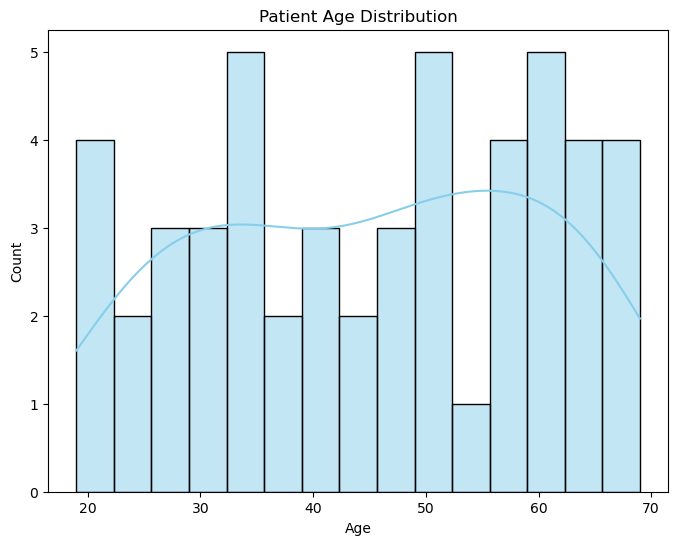

In [69]:
plt.figure(figsize=(8,6))
sns.histplot(df_patients['Age'], bins=15, kde=True, color='skyblue')
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


# 📈 Show vs No-Show Pie Chart


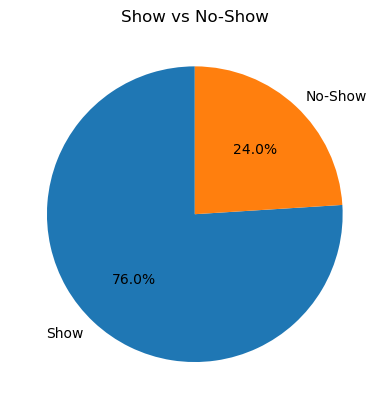

In [26]:
df_appointments['Status'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Show vs No-Show")
plt.ylabel('')
plt.show()


# Busy Days Bar


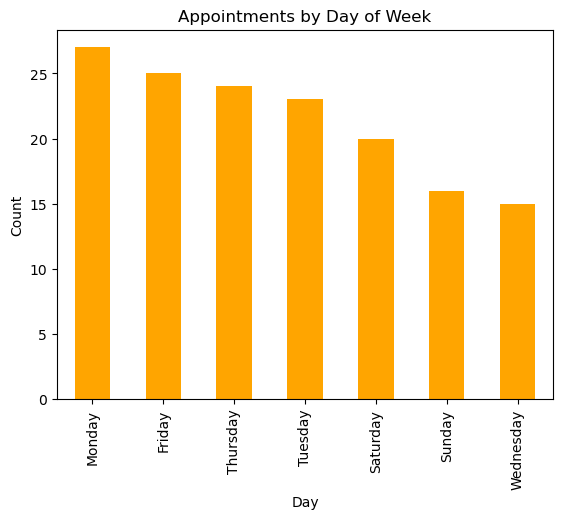

In [28]:
busy_days.plot(kind='bar', color='orange')
plt.title("Appointments by Day of Week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.show()

# Specialties Bar


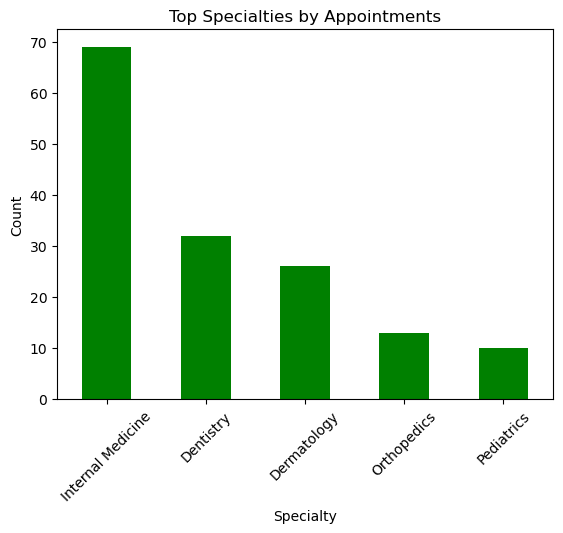

In [30]:
specialties.plot(kind='bar', color='green')
plt.title("Top Specialties by Appointments")
plt.xlabel("Specialty")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Correlation Heatmap


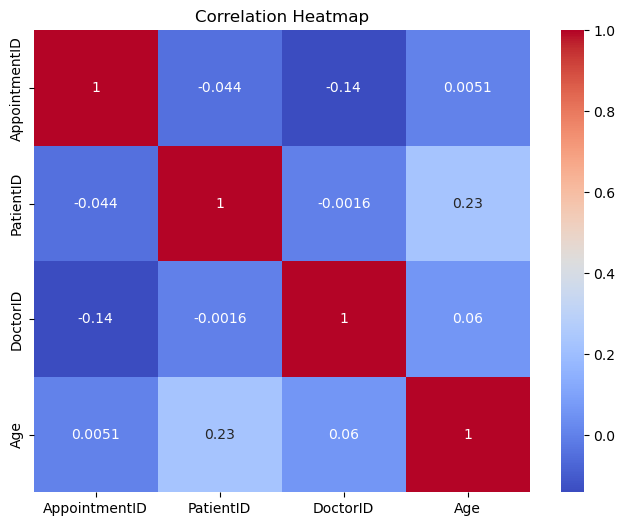

In [32]:
plt.figure(figsize=(8,6))
sns.heatmap(df_merged.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Total Expenses per Type


C:\Users\moham\AppData\Local\Temp\ipykernel_12200\3903081132.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=expenses_per_type.values, y=expenses_per_type.index, palette="viridis")


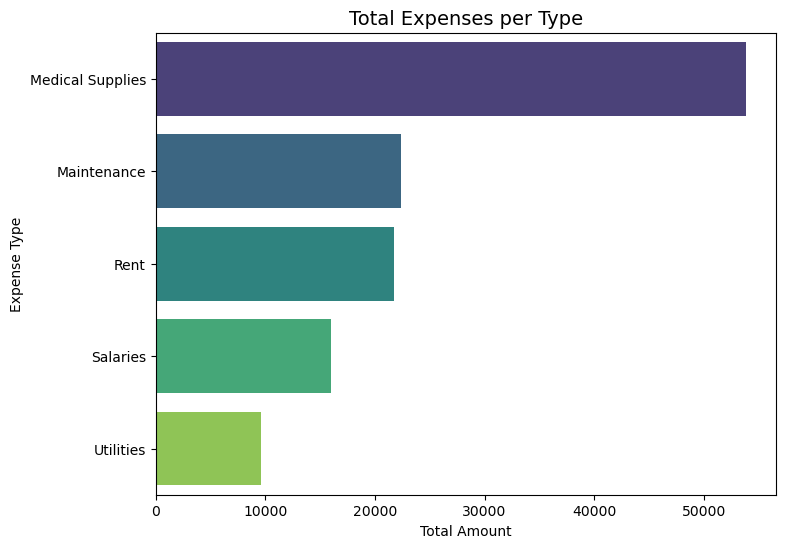

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# حساب إجمالي المصروفات لكل نوع
expenses_per_type = df_expenses.groupby('Type')['Amount'].sum().sort_values(ascending=False)

# رسم بياني عمودي
plt.figure(figsize=(8,6))
sns.barplot(x=expenses_per_type.values, y=expenses_per_type.index, palette="viridis")

plt.title("Total Expenses per Type", fontsize=14)
plt.xlabel("Total Amount")
plt.ylabel("Expense Type")
plt.show()


# 📈 Step 6: Revenue Forecasting (Linear Regression)


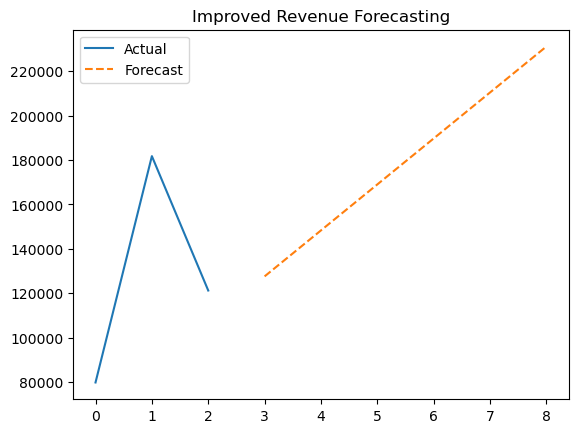

In [34]:

df_revenues['Month'] = df_revenues['Date'].dt.month
df_revenues['Year'] = df_revenues['Date'].dt.year
monthly_rev = df_revenues.groupby(['Year','Month'])['Revenue'].sum().reset_index()
monthly_rev['MonthIndex'] = np.arange(len(monthly_rev))

# One-hot encoding for months
monthly_rev_encoded = pd.get_dummies(monthly_rev[['Month','Year']], drop_first=True)
X = pd.concat([monthly_rev[['MonthIndex']], monthly_rev_encoded], axis=1)
y = monthly_rev['Revenue']

# Model
model = LinearRegression()
model.fit(X, y)

# Predict next 6 months
future_months = pd.DataFrame({
    'MonthIndex': np.arange(len(monthly_rev), len(monthly_rev)+6),
    'Month': [(m % 12) + 1 for m in range(len(monthly_rev), len(monthly_rev)+6)],
    'Year': [2025]*6
})
future_months_encoded = pd.get_dummies(future_months[['Month','Year']], drop_first=True)
future_months_encoded = future_months_encoded.reindex(columns=monthly_rev_encoded.columns, fill_value=0)
future_preds = model.predict(pd.concat([future_months[['MonthIndex']], future_months_encoded], axis=1))

# Plot
plt.plot(monthly_rev['MonthIndex'], y, label='Actual')
plt.plot(future_months['MonthIndex'], future_preds, label='Forecast', linestyle='--')
plt.title("Improved Revenue Forecasting")
plt.legend()
plt.show()


# 🤖 Step 7: K-Means Clustering for Patients



C:\Users\moham\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\moham\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\moham\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\moham\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

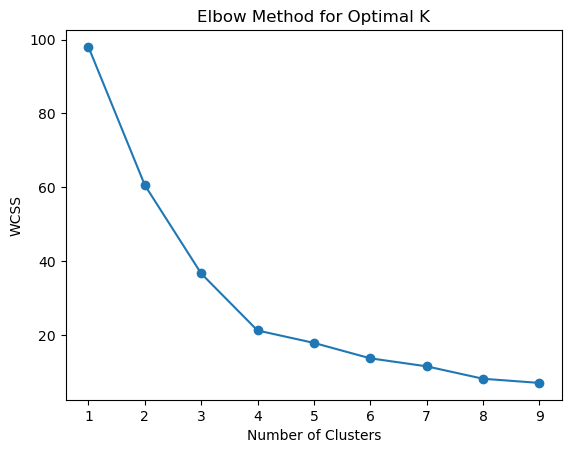

C:\Users\moham\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


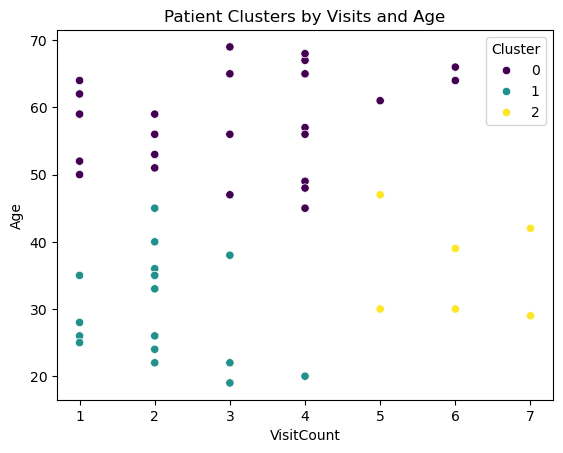

In [36]:

# Prepare Data
visit_counts = df_appointments['PatientID'].value_counts().reset_index()
visit_counts.columns = ['PatientID', 'VisitCount']
df_cluster = visit_counts.merge(df_patients[['PatientID', 'Age']], on='PatientID', how='left')
X_cluster = df_cluster[['VisitCount', 'Age']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Elbow Method
wcss = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 10), wcss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

# Fit K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

# Plot Clusters
sns.scatterplot(data=df_cluster, x='VisitCount', y='Age', hue='Cluster', palette='viridis')
plt.title("Patient Clusters by Visits and Age")
plt.show()


# 📀 Step 8: Save Results


In [38]:

df_cluster.to_csv("patient_clusters.csv", index=False)
monthly_rev.to_csv("monthly_revenue.csv", index=False)
attendance_rate_specialty.to_csv("attendance_rate_specialty.csv")
avg_age_specialty.to_csv("avg_age_specialty.csv")
